In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from src.numpyLSTM.MewralLSTM import MewralOldLSTM 

# --- 1. Data Generator (Adding Problem) ---
def get_adding_problem_batch(batch_size, seq_len):
    inputs = []
    targets = []
    for _ in range(batch_size):
        # 1. Generate Input Channel (Random Noise [-1, 1])
        values = np.random.uniform(-1, 1, (seq_len, 1))
        
        # 2. Generate Marker Channel (Sparse 0 or 1)
        markers = np.zeros((seq_len, 1))
        
        # Randomly pick two positions
        # Marker 1: First 10%
        idx1 = np.random.randint(0, int(seq_len * 0.1))
        # Marker 2: Middle 50%
        idx2 = np.random.randint(int(seq_len * 0.5), int(seq_len * 0.6))
        
        markers[idx1] = 1.0
        markers[idx2] = 1.0
        
        # Combine into (Seq, 2)
        inp = np.hstack((values, markers))
        
        # 3. Calculate Target (Scaled)
        true_sum = values[idx1] + values[idx2]
        
        # Scale to [0, 1] for Sigmoid/Tanh output compatibility
        # Range of sum is [-2, 2]. 
        # (sum / 4.0) is [-0.5, 0.5]. 
        # + 0.5 shifts it to [0.0, 1.0].
        scaled_target = 0.5 + (true_sum / 4.0)
        
        targ = np.zeros((seq_len, 1))
        targ[-1] = scaled_target 
        
        inputs.append(inp)
        targets.append(targ)
        
    return inputs, targets

Applying 1997 Bias Initialization...

Starting STREAK TEST.
Target: 1000 consecutive correct sequences.
Criterion: Absolute Error < 0.04
Trial 0: Current Streak = 0 | Avg Err (Last 100) = 0.6271
Trial 500: Current Streak = 0 | Avg Err (Last 100) = 0.1903
Trial 1000: Current Streak = 0 | Avg Err (Last 100) = 0.1731
Trial 1500: Current Streak = 0 | Avg Err (Last 100) = 0.1932
Trial 2000: Current Streak = 0 | Avg Err (Last 100) = 0.1682
Trial 2500: Current Streak = 0 | Avg Err (Last 100) = 0.1624
Trial 3000: Current Streak = 0 | Avg Err (Last 100) = 0.2120
Trial 3500: Current Streak = 0 | Avg Err (Last 100) = 0.2047
Trial 4000: Current Streak = 0 | Avg Err (Last 100) = 0.1602
Trial 4500: Current Streak = 1 | Avg Err (Last 100) = 0.2012
Trial 5000: Current Streak = 0 | Avg Err (Last 100) = 0.1653
Trial 5500: Current Streak = 0 | Avg Err (Last 100) = 0.1333
Trial 6000: Current Streak = 2 | Avg Err (Last 100) = 0.0755
Trial 6500: Current Streak = 0 | Avg Err (Last 100) = 0.0587
Trial 7000: C

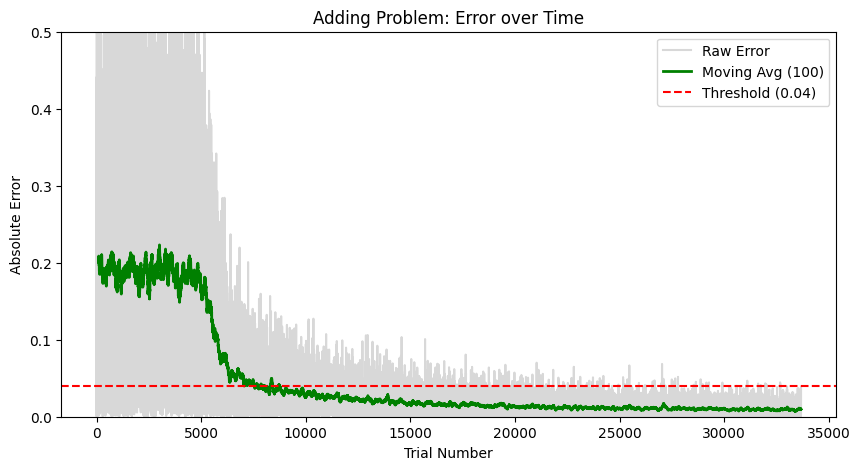

In [4]:
# --- 2. Experiment Setup ---
SEQ_LENGTH = 100
INPUT_SIZE = 2
HIDDEN_SIZE = 20 
LAYERS = 1
OUTPUT_SIZE = 1

# Initialize Model
lstm = MewralOldLSTM(INPUT_SIZE, HIDDEN_SIZE, LAYERS, OUTPUT_SIZE, optimizer="sgd")

# --- 3. THE 1997 PAPER CONFIGURATION ---
print("Applying 1997 Bias Initialization...")

# Shift biases to close the gates (Negative bias = Closed)
# This forces the LSTM to learn ONLY when the marker signal is strong enough to open the gate.
lstm.shift_baises(-3.0, -3.0) 

# Learning Rate must be high to punch through the closed gates
LEARNING_RATE = 0.5

# --- 4. The Streak Loop ---
SUCCESS_THRESHOLD = 0.04  # Strict 1997 criterion
GOAL_CONSECUTIVE = 1000   # Consecutive wins required
MAX_TRIALS = 200000       

consecutive_wins = 0
history = []

print(f"\nStarting STREAK TEST.")
print(f"Target: {GOAL_CONSECUTIVE} consecutive correct sequences.")
print(f"Criterion: Absolute Error < {SUCCESS_THRESHOLD}")

for trial in range(MAX_TRIALS):
    # Get 1 random sequence
    input_batch, target_batch = get_adding_problem_batch(1, SEQ_LENGTH)
    
    # Extract arrays from list
    inputs = input_batch[0]   # Shape (100, 2)
    targets = target_batch[0] # Shape (100, 1)
        
    # --- THE FIX: ADD BATCH DIMENSION ---
    # Reshape from (100, 2) -> (100, 1, 2)
    inputs = inputs.reshape(SEQ_LENGTH, 1, INPUT_SIZE)
    # Reshape from (100, 1) -> (100, 1, 1)
    targets = targets.reshape(SEQ_LENGTH, 1, OUTPUT_SIZE)
    
    # Update the reference for the "real target" check
    real_target = targets[-1][0][0] 

    # --- Check Prediction ---
    lstm.last_batch_short_term_memory = None 
    preds, _, _ = lstm.forward(inputs, retain_state=False)
    
    # Extract scalar prediction
    # preds is (100, 1, 1) -> [-1] is (1, 1) -> [0,0] is scalar
    prediction = preds[-1][0, 0]
    
    # Calculate Error
    abs_error = abs(prediction - real_target)
    history.append(abs_error)
    
    # --- Check Streak Status ---
    if abs_error < SUCCESS_THRESHOLD:
        consecutive_wins += 1
    else:
        if consecutive_wins > 50:
            print(f" > Streak Broken at {consecutive_wins}. Error: {abs_error:.4f} (Target: {real_target:.2f}, Pred: {prediction:.2f})")
        consecutive_wins = 0 

    # --- Train ---
    # Using 'last_step' as requested (which uses MSE internally in your class)
    lstm.BPTT(inputs, targets, learning_rate=LEARNING_RATE, loss_mode="last_step", retain_state=False)

    # --- Success Check ---
    if consecutive_wins >= GOAL_CONSECUTIVE:
        print(f"\n\n✅ VICTORY! Reached {GOAL_CONSECUTIVE} consecutive successes.")
        print(f"Total Trials: {trial}")
        print(f"Final Error: {abs_error:.5f}")
        break

    # --- Logging ---
    if trial % 500 == 0:
        # Calculate moving average of last 100 errors
        avg_err = np.mean(history[-100:] if len(history) > 100 else history)
        print(f"Trial {trial}: Current Streak = {consecutive_wins} | Avg Err (Last 100) = {avg_err:.4f}")

# --- Plot ---
plt.figure(figsize=(10, 5))
plt.plot(history, alpha=0.3, label='Raw Error', color='gray')

# Rolling average to see trend better
window = 100
if len(history) > window:
    rolling_mean = np.convolve(history, np.ones(window)/window, mode='valid')
    plt.plot(np.arange(window-1, len(history)), rolling_mean, 'g', linewidth=2, label='Moving Avg (100)')

plt.axhline(y=SUCCESS_THRESHOLD, color='r', linestyle='--', label='Threshold (0.04)')
plt.ylim(0, 0.5)
plt.title("Adding Problem: Error over Time")
plt.xlabel("Trial Number")
plt.ylabel("Absolute Error")
plt.legend()
plt.show()

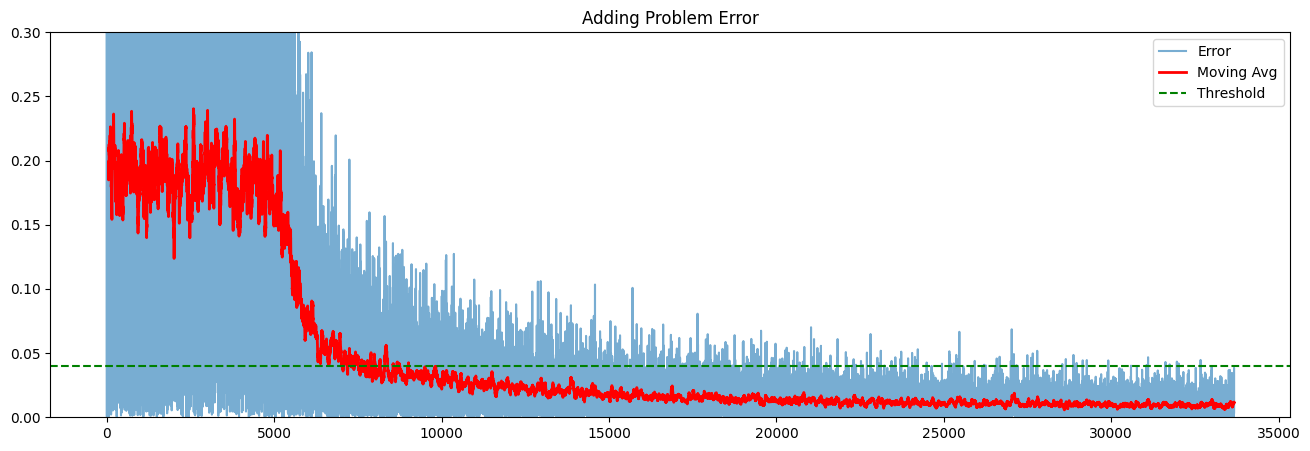

In [10]:
plt.figure(figsize=(16, 5))
plt.plot(history, alpha=0.6, label='Error')
# Rolling average to see trend better
window = 50
if len(history) > window:
    rolling_mean = np.convolve(history, np.ones(window)/window, mode='valid')
    plt.plot(np.arange(window-1, len(history)), rolling_mean, 'r', linewidth=2, label='Moving Avg')

plt.axhline(y=SUCCESS_THRESHOLD, color='g', linestyle='--', label='Threshold')
plt.ylim(0, 0.3)
plt.title("Adding Problem Error")
plt.legend()
plt.show()


--- STARTING RNN CONTROL TEST ---
Goal: 500 consecutive correct sequences.
Note: Standard RNN is expected to FAIL due to Vanishing Gradients.
Trial 0: Streak = 0 | Avg Err = 0.9036
Trial 1000: Streak = 0 | Avg Err = 0.1767
Trial 2000: Streak = 0 | Avg Err = 0.1689
Trial 3000: Streak = 0 | Avg Err = 0.1742
Trial 4000: Streak = 1 | Avg Err = 0.1835
Trial 5000: Streak = 1 | Avg Err = 0.1763
Trial 6000: Streak = 0 | Avg Err = 0.1774
Trial 7000: Streak = 0 | Avg Err = 0.1665
Trial 8000: Streak = 0 | Avg Err = 0.1682
Trial 9000: Streak = 0 | Avg Err = 0.1869
Trial 10000: Streak = 0 | Avg Err = 0.1697
Trial 11000: Streak = 0 | Avg Err = 0.2012
Trial 12000: Streak = 0 | Avg Err = 0.1790
Trial 13000: Streak = 0 | Avg Err = 0.1944
Trial 14000: Streak = 0 | Avg Err = 0.1621
Trial 15000: Streak = 0 | Avg Err = 0.1733
Trial 16000: Streak = 0 | Avg Err = 0.1693
Trial 17000: Streak = 0 | Avg Err = 0.1903
Trial 18000: Streak = 0 | Avg Err = 0.1640
Trial 19000: Streak = 0 | Avg Err = 0.1747
Trial 2000

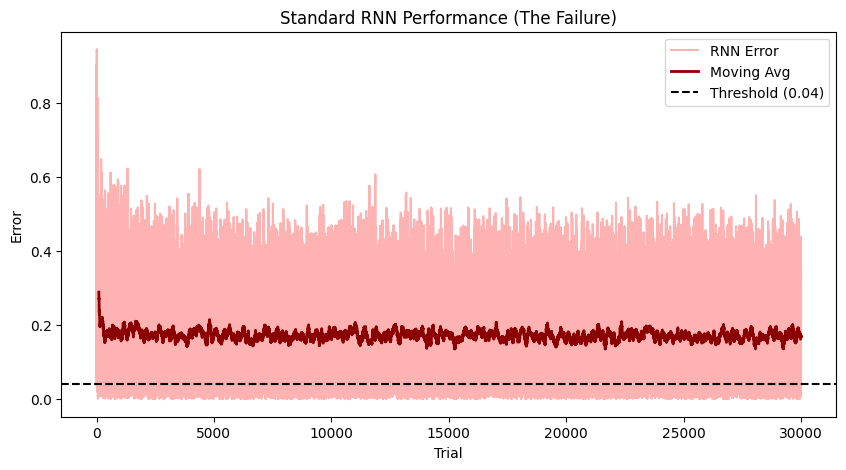

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from src.numpyLSTM.StandardRNN import RecurrentMewralNet

# --- 1. Data Generator (Same as before) ---
def get_adding_problem_batch(batch_size, seq_len):
    inputs = []
    targets = []
    for _ in range(batch_size):
        values = np.random.uniform(-1, 1, (seq_len, 1))
        markers = np.zeros((seq_len, 1))
        idx1 = np.random.randint(0, int(seq_len * 0.1))
        idx2 = np.random.randint(int(seq_len * 0.5), int(seq_len * 0.6))
        markers[idx1] = 1.0
        markers[idx2] = 1.0
        inp = np.hstack((values, markers))
        
        true_sum = values[idx1] + values[idx2]
        scaled_target = 0.5 + (true_sum / 4.0)
        
        targ = np.zeros((seq_len, 1))
        targ[-1] = scaled_target 
        inputs.append(inp)
        targets.append(targ)
    return inputs, targets

# --- 2. Experiment Setup ---
SEQ_LENGTH = 100
INPUT_SIZE = 2
HIDDEN_SIZE = 20 # Same size as LSTM
OUTPUT_SIZE = 1

# Initialize Standard RNN
rnn = RecurrentMewralNet(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, initialzation="xavier")

# RNNs are unstable, so we use a smaller Learning Rate
LEARNING_RATE = 0.01 

# --- 3. The Streak Loop ---
SUCCESS_THRESHOLD = 0.04  
GOAL_CONSECUTIVE = 500    
MAX_TRIALS = 30000 # Lower limit because we don't expect it to succeed

consecutive_wins = 0
history = []

print(f"\n--- STARTING RNN CONTROL TEST ---")
print(f"Goal: {GOAL_CONSECUTIVE} consecutive correct sequences.")
print(f"Note: Standard RNN is expected to FAIL due to Vanishing Gradients.")

for trial in range(MAX_TRIALS):
    # Get Data
    input_batch, target_batch = get_adding_problem_batch(1, SEQ_LENGTH)
    inputs = input_batch[0]   # (100, 2)
    targets = target_batch[0] # (100, 1)
    
    # Reshape for matrix operations (Time, Batch, Features)
    inputs = inputs.reshape(SEQ_LENGTH, 1, INPUT_SIZE)
    targets = targets.reshape(SEQ_LENGTH, 1, OUTPUT_SIZE)
    real_target = targets[-1][0][0]

    # --- Forward Pass ---
    # Note: StandardRNN usually takes inputs directly in (Time, Batch, Feat)
    preds, _ = rnn.forward(inputs)
    prediction = preds[-1][0, 0]
    
    # --- Check Error ---
    abs_error = abs(prediction - real_target)
    history.append(abs_error)
    
    if abs_error < SUCCESS_THRESHOLD:
        consecutive_wins += 1
    else:
        consecutive_wins = 0 


    rnn.BPTT(inputs, targets, LEARNING_RATE, loss_mask="last_step")

    # --- Logging ---
    if trial % 1000 == 0:
        avg_err = np.mean(history[-100:] if len(history) > 100 else history)
        print(f"Trial {trial}: Streak = {consecutive_wins} | Avg Err = {avg_err:.4f}")
        
    if consecutive_wins >= GOAL_CONSECUTIVE:
        print(f"VICTORY! RNN solved it! (This is highly unlikely)")
        break

# --- Plot ---
plt.figure(figsize=(10, 5))
plt.plot(history, alpha=0.3, color='red', label='RNN Error')
window = 100
if len(history) > window:
    rolling_mean = np.convolve(history, np.ones(window)/window, mode='valid')
    plt.plot(np.arange(window-1, len(history)), rolling_mean, 'darkred', linewidth=2, label='Moving Avg')

plt.axhline(y=SUCCESS_THRESHOLD, color='black', linestyle='--', label='Threshold (0.04)')
plt.title("Standard RNN Performance (The Failure)")
plt.xlabel("Trial")
plt.ylabel("Error")
plt.legend()
plt.show()